# Analiza zbioru danych związanych z katastrofą Titanica
### Na podsawie poniższej analizy chciałbym zobaczyć i określić czynniki związane z przeżywalonością pasażerów statku

## 1. Określenie Problemu
### Zrozumienie wpływu czynników decydujących na przezprzywalności pasażerów podczas katastrofy Titanica.
* Czy istnieje różnica w szansach przeżycia między mężczyznami a kobietami?
* Czy klasa biletu związna była z większą szansą przeżycia?
* Czy wiek pasażera miał wpływ na jego szanse przeżycia?
* Czy inne czynniki, takie jak stan cywilny, wielkość rodziny, bądz miejsce na statku miały istone znaczenie.

## 2. Wstępne zapoznanie się z danymi 
### Załadowanie podstawowych bibliotek, oraz bazy danych.

In [1]:
#Obliczenia  i analiza  danych
import numpy as np
import pandas as pd

#wizualiacja 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
sns.set_palette('icefire', 5)

%matplotlib inline
#Przetwarzanie

from sklearn.preprocessing import OneHotEncoder

# Baza danych
Titanic = pd.read_csv("Titanic_Database.csv") 

In [2]:
Titanic.head(8)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S


In [3]:
print(Titanic.columns)

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


### Zbiór danych zawiera następujące informacje:

*  PassengerId: Unikatowy identyfikator pasażera
*  Survived: Czy pasażer przeżył (1) czy zginął (0)
*  Pclass: Klasa biletu (1=pierwsza, 2=druga, 3=trzecia)
*  Name: Imię i nazwisko pasażera, staus cywilny
*  Sex: Płeć pasażera (male, female)
*  Age: Wiek pasażera
*  SibSp: Liczba rodzeństwa i/lub małżonka na pokładzie
*  Parch: Liczba rodziców i/lub dzieci na pokładzie
*  Ticket: Numer biletu
*  Fare: Cena biletu
*  Cabin: Numer kabiny
*  Embarked: Port zaokrętowania (C = Cherbourg, Q = Queenstown, S = Southampton)

In [4]:
Titanic.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


## 3. Czyszczenie i przygotowanie danych

In [5]:
#Sprawdzenie wartości zerowych
print(pd.isnull(Titanic).sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


### Przygotowanie danych

In [6]:
Titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


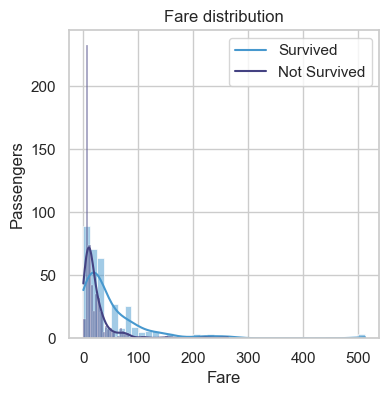

In [7]:
fig, axes = plt.subplots(figsize=(4,4))
axes.set_ylabel('Passengers')
axes.set_title('Fare distribution')
sns.histplot(Titanic[Titanic['Survived']==1]['Fare'],kde=True)
sns.histplot(Titanic[Titanic['Survived']==0]['Fare'],kde=True)
axes.legend(['Survived','Not Survived'])

In [8]:
## Powyższa grafika wskazuje dlaczego decyduję się nie dyskretyzować/encodować danych. Wykorzsytam dane w sposób ciągły. Dlasze rozważenia nad podzielenm tego zostną rowważone wyłącznie gddy prześlę to dla ML Kaggle.
# Mapping Fare
#Titanic.loc[Titanic['Fare'] <=  7.895800,                                 'Fare'] = 0
#Titanic.loc[(Titanic['Fare'] >  7.895800) & (Titanic['Fare'] <= 14.4542), 'Fare'] = 1
#Titanic.loc[(Titanic['Fare'] > 14.4542)   & (Titanic['Fare'] <=  31.5),   'Fare'] = 2
#Titanic.loc[Titanic['Fare'] >  31.5,                                      'Fare'] = 3
#Titanic['Fare'].value_counts()

####  Określenie stanu cywilnego danego paseżera.

In [9]:
def get_title(name):
    # Wyodrębnij prefix z imienia
    title = name.split(',')[1].split('.')[0].strip()
    if title in ['Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona']:
        return 'Rare'
    elif title in ['Mlle']:
        return 'Miss'
    elif title in ['Ms']:
        return 'Miss'
    elif title in ['Mme']:
        return 'Mrs'
    else:
        return title
Titanic['Title'] = Titanic['Name'].apply(get_title)
title_percentages = Titanic['Title'].value_counts(normalize=True)
print(title_percentages)

Title
Mr              0.580247
Miss            0.207632
Mrs             0.141414
Master          0.044893
Rare            0.024691
the Countess    0.001122
Name: proportion, dtype: float64


### OneHotencodowanie danych categorycznych

In [10]:
# Import OneHotEncoder from scikit-learn
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse_output=False)  # Set sparse_output=False for dense output
categorical_features = ['Sex', 'Embarked', 'Title']
encoded_features = ohe.fit_transform(Titanic[categorical_features])

# Add encoded columns to DataFrame
for i, col in enumerate(categorical_features):
    Titanic[col + "_Enc"] = encoded_features[:, i]

## Create mapping dictionary (optional)
#ohe_mapping = {}
#for i, col in enumerate(categorical_features):
#    categories = ohe.categories_[i]
#    encoded_values = range(len(categories))
#    mapping = dict(zip(categories, encoded_values))
#    ohe_mapping[col] = mapping
#
# Print mapping for each column (if using ohe_mapping)
#for col in categorical_features:
#    print(f"Kolumna: {col}")
#    if 'ohe_mapping' in locals():  # Check if ohe_mapping was created
#        mapping = ohe_mapping[col]
#        for category, encoded_value in mapping.items():
#            print(f"  {category}: {encoded_value}")
#    else:
#        print(f"  Mapping not created. Use 'ohe_mapping' for category-to-encoding lookup.")
#    print()

In [11]:
### Sumaryczne wyniki/punkt odniesnia dla danych kattegorycznych, kótóre zostały zencodowane. 

## Wybór danych
#### Ocena kategorii, które mogą zostać bezwzględnie usunięte nie planuję ich brać w dalszej części lub zostały zencodowane. Oczywiście pełne usprawidliwnie powinno pojawić się tutaj tłumacząc dlaczego obecność danej kategorii nie wnośi niczego co mógłbym wykorzystać dalej do modelu, jednak nie mieszam kroków. Wskazanie danych newraligcznych znajdue się w dalszej częscie pod wizulaizacją.  

In [12]:
# Usuń oryginalne kolumny
categorical_features = ['PassengerId','Name', 'Title', 'Sex', 'Ticket','Cabin', 'Embarked']
Titanic.drop(columns=categorical_features, inplace=True)
Titanic.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_Enc,Embarked_Enc,Title_Enc
0,0,3,22.0,1,0,7.2500,0.0,1.0,0.0
1,1,1,38.0,1,0,71.2833,1.0,0.0,1.0
2,1,3,26.0,0,0,7.9250,1.0,0.0,0.0
3,1,1,35.0,1,0,53.1000,1.0,0.0,0.0
4,0,3,35.0,0,0,8.0500,0.0,1.0,0.0


In [13]:
Titanic[['Age', 'Fare']] = Titanic[['Age', 'Fare']].astype(np.float32)
columns_to_convert = ['Survived' ,'Pclass', 'SibSp', 'Parch', 'Sex_Enc', 'Embarked_Enc', 'Title_Enc']
Titanic[columns_to_convert] = Titanic[columns_to_convert].astype(np.int16)
Titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Survived      891 non-null    int16  
 1   Pclass        891 non-null    int16  
 2   Age           714 non-null    float32
 3   SibSp         891 non-null    int16  
 4   Parch         891 non-null    int16  
 5   Fare          891 non-null    float32
 6   Sex_Enc       891 non-null    int16  
 7   Embarked_Enc  891 non-null    int16  
 8   Title_Enc     891 non-null    int16  
dtypes: float32(2), int16(7)
memory usage: 19.3 KB


In [14]:
Titanic

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_Enc,Embarked_Enc,Title_Enc
0,0,3,22.0,1,0,7.250000,0,1,0
1,1,1,38.0,1,0,71.283302,1,0,1
2,1,3,26.0,0,0,7.925000,1,0,0
3,1,1,35.0,1,0,53.099998,1,0,0
4,0,3,35.0,0,0,8.050000,0,1,0
...,...,...,...,...,...,...,...,...,...
886,0,2,27.0,0,0,13.000000,0,1,0
887,1,1,19.0,0,0,30.000000,1,0,0
888,0,3,NaN,1,2,23.450001,1,0,0
889,1,1,26.0,0,0,30.000000,0,1,1


## 4. Wizualizacja i ekspoloracja wzorców

In [15]:
Titanic.groupby('Sex_Enc').mean().round(2)

,Survived,Pclass,Age,SibSp,Parch,Fare,Embarked_Enc,Title_Enc
Sex_Enc,,,,,,,,
0,0.19,2.39,30.73,0.43,0.24,25.52,1.0,0.16
1,0.74,2.16,27.92,0.69,0.65,44.48,0.0,0.23


In [16]:
Titanic.groupby('Survived').mean().round(2)

,Pclass,Age,SibSp,Parch,Fare,Sex_Enc,Embarked_Enc,Title_Enc
Survived,,,,,,,,
0,2.53,30.629999,0.55,0.33,22.120001,0.15,0.85,0.14
1,1.95,28.340000,0.47,0.46,48.400002,0.68,0.32,0.27


Text(0.5, 1.05, 'Pearson Correlation of Features')

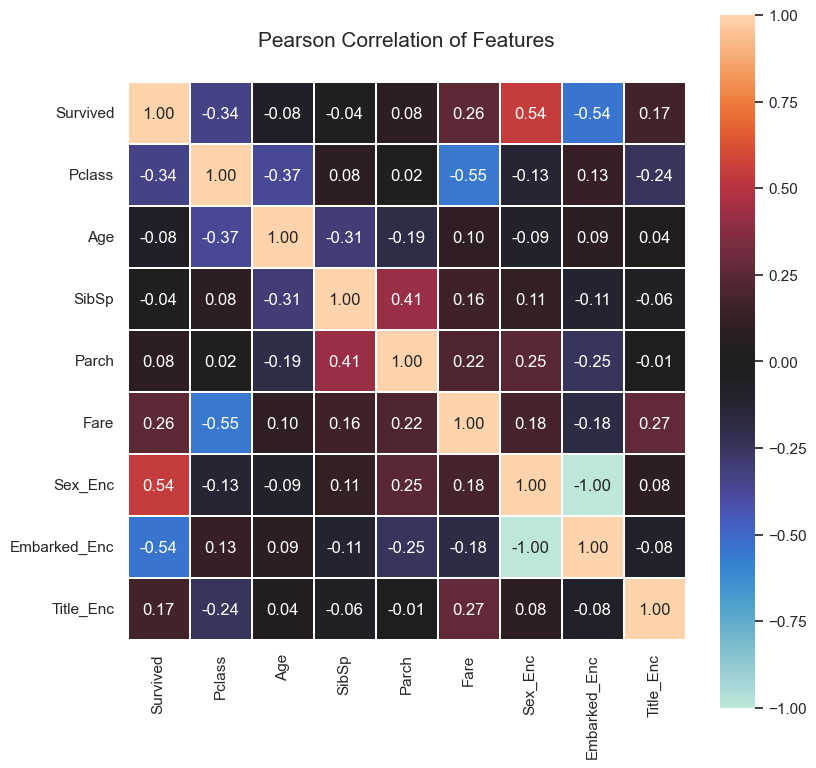

In [17]:
fig, ax = plt.subplots(figsize=(9, 9))
sns.heatmap(Titanic.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, linecolor='white', annot=True, cmap= 'icefire', fmt=".2f")
ax.set_title('Pearson Correlation of Features', y=1.05, size=15)

In [18]:
#sns.pairplot(Titanic, hue="Survived", kind="kde", corner=True)

###  Rozkład  wieku  pasażerów

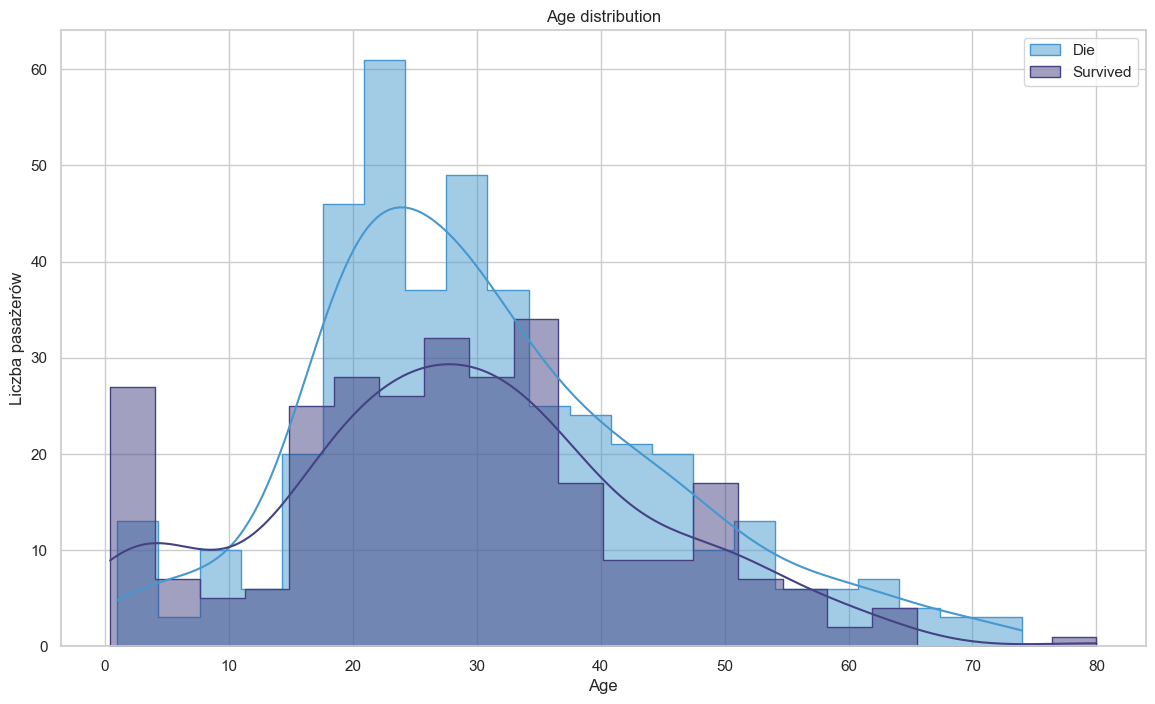

In [19]:
fig, axes = plt.subplots(figsize=(14,8))
axes.set_ylabel('Liczba pasażerów')
axes.set_xlabel('Age')
axes.set_title('Age distribution')
sns.histplot(Titanic[Titanic['Survived']==0]['Age'],kde=True, bins=22, element='step', label='Die')
sns.histplot(Titanic[Titanic['Survived']==1]['Age'],kde=True, bins=22, element='step', label='Survived')
axes.legend()

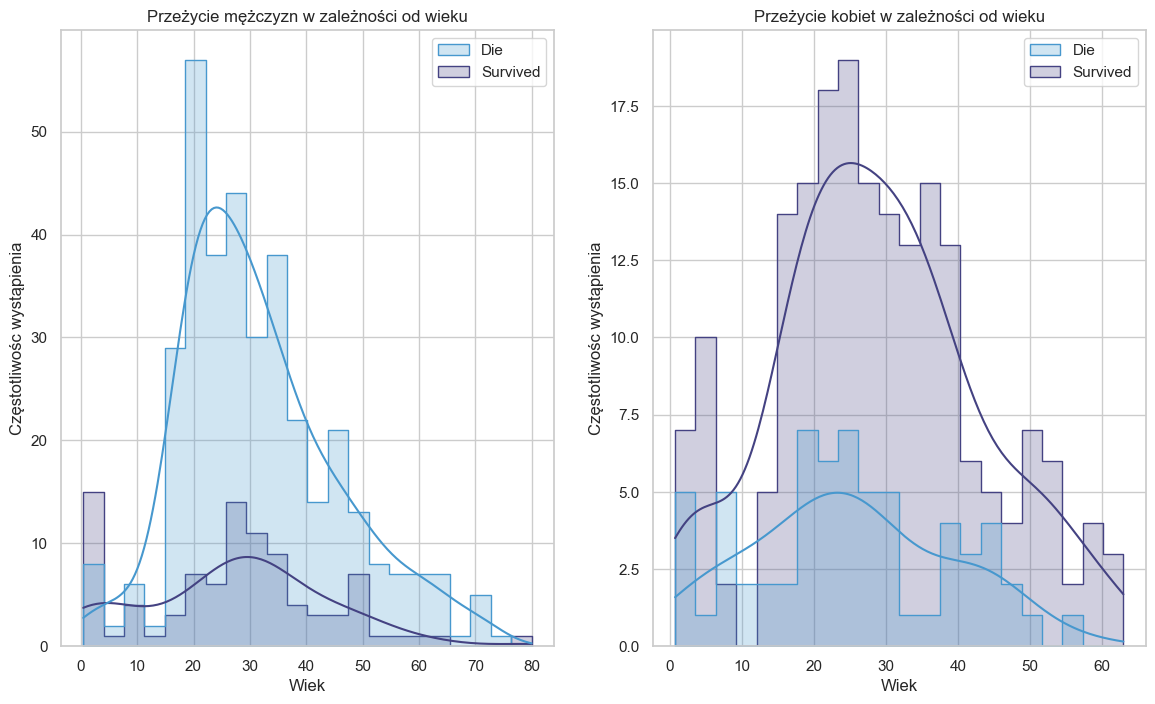

In [20]:
# dwa wykresy
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14, 8))
# Mężczyźni
sns.histplot(Titanic[Titanic['Sex_Enc']==0], x='Age', hue='Survived', element='step', common_norm=False, ax=ax1, bins=22, kde=True)
ax1.set_xlabel('Wiek')
ax1.set_ylabel('Liczba przypadków')
ax1.set_title('Przeżycie mężczyzn w zależności od wieku')
legend = ax1.get_legend()
handles = legend.legend_handles
ax1.legend(handles, ['Die', 'Survived'])
# Kobiety
sns.histplot(Titanic[Titanic['Sex_Enc']==1], x='Age', hue='Survived', element='step', common_norm=False, ax=ax2, bins=22, kde=True)
ax2.set_xlabel('Wiek')
ax2.set_ylabel('CLiczba przypadków')
ax2.set_title('Przeżycie kobiet w zależności od wieku')
legend = ax2.get_legend()
handles = legend.legend_handles
ax2.legend(handles, ['Die', 'Survived'])

Text(0.5, 0, 'Płeć | mężczyzn = 0 | kobiett =1 ')

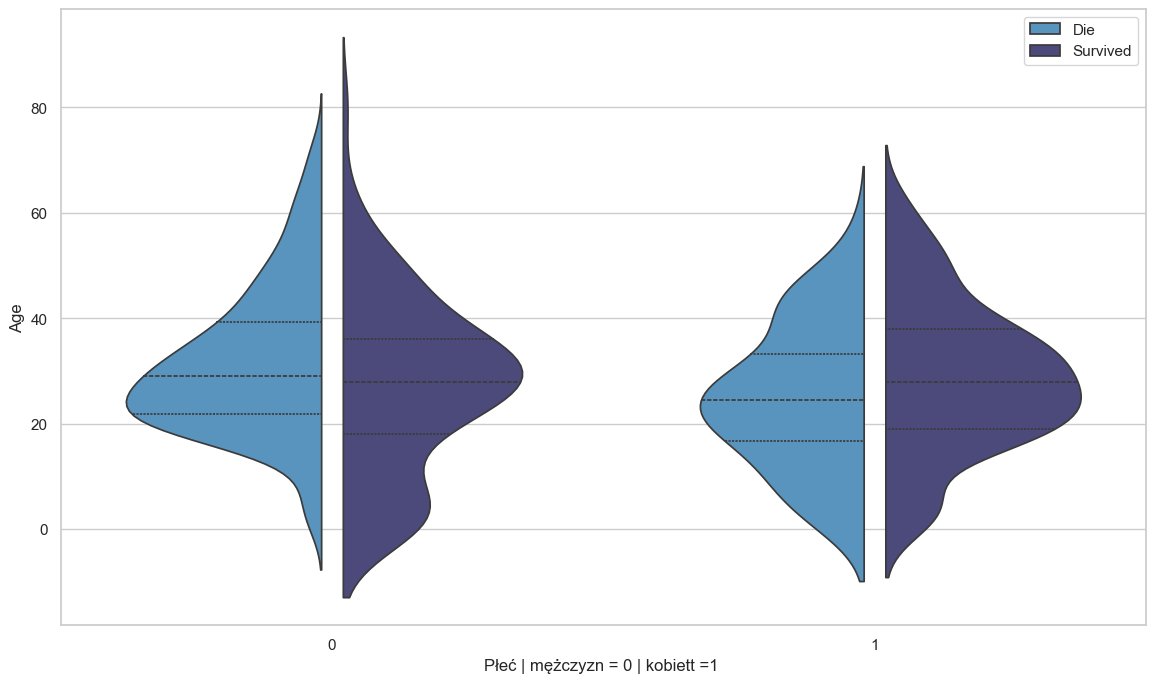

In [25]:
fig, ax = plt.subplots(figsize=(14,8))
sns.violinplot(data=Titanic, x="Sex_Enc", y="Age", hue="Survived", split=True, gap=.1, inner="quart")
legend = ax.get_legend()
handles = legend.legend_handles
ax.legend(handles, ['Die', 'Survived'])
ax.set_xlabel('Płeć | mężczyzn = 0 | kobiett =1 ')

Pamiętajmy, że wysokośc  wartośc odciętrych na violon plocie nie wskazuje częstotoliwości występowania danego zdarzenia. W wziązku z czym kluczowa analiza powinna opierać się głownie na porównaniu krzywej do maksimum. 


## wiek  vs Fare (hue przeżywalność) czy liniowo zależne


<Axes: xlabel='Pclass', ylabel='Fare'>

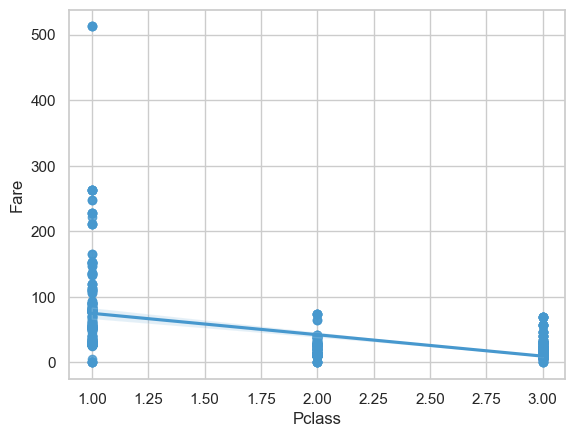

In [22]:
sns.regplot(data=Titanic, x="Pclass", y="Fare")


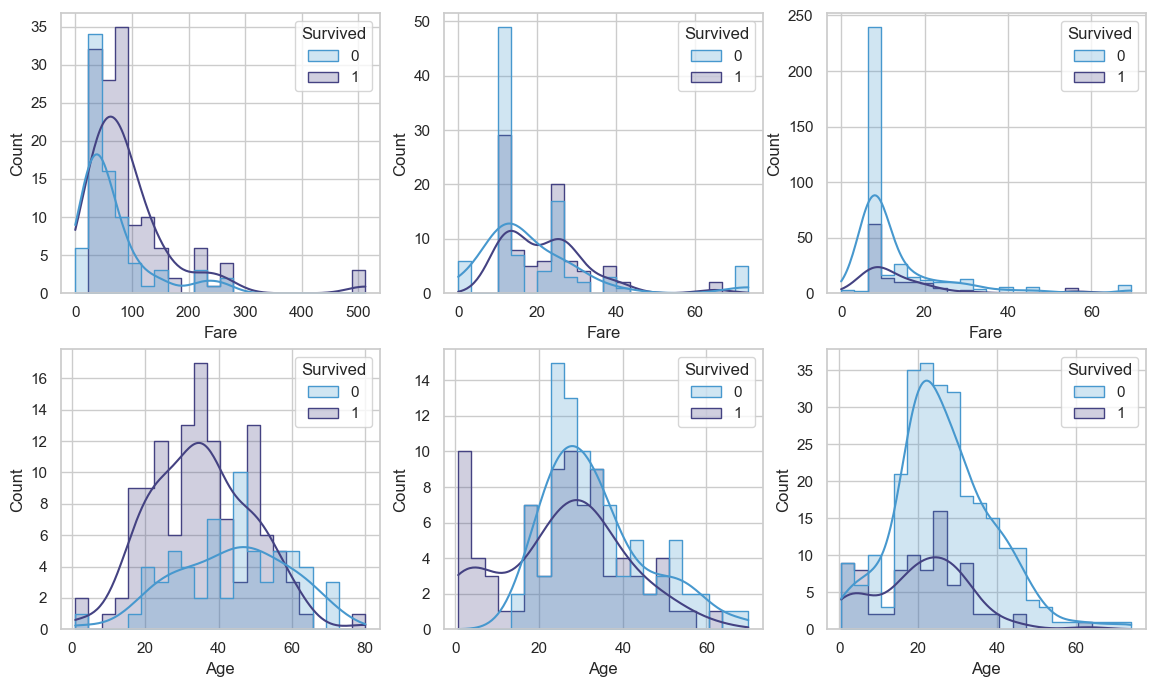

In [23]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(14, 8))

# Create histograms for fares (loop over first row)
for i in range(3):
  sns.histplot(Titanic[Titanic['Pclass']==(i+1)], x='Fare', hue='Survived', element='step', common_norm=False, ax=axes[0, i], bins=22, kde=True)

# Create histograms for age (loop over second row)
for i in range(3):
  sns.histplot(Titanic[Titanic['Pclass']==(i+1)], x='Age', hue='Survived', element='step', common_norm=False, ax=axes[1, i], bins=22, kde=True)


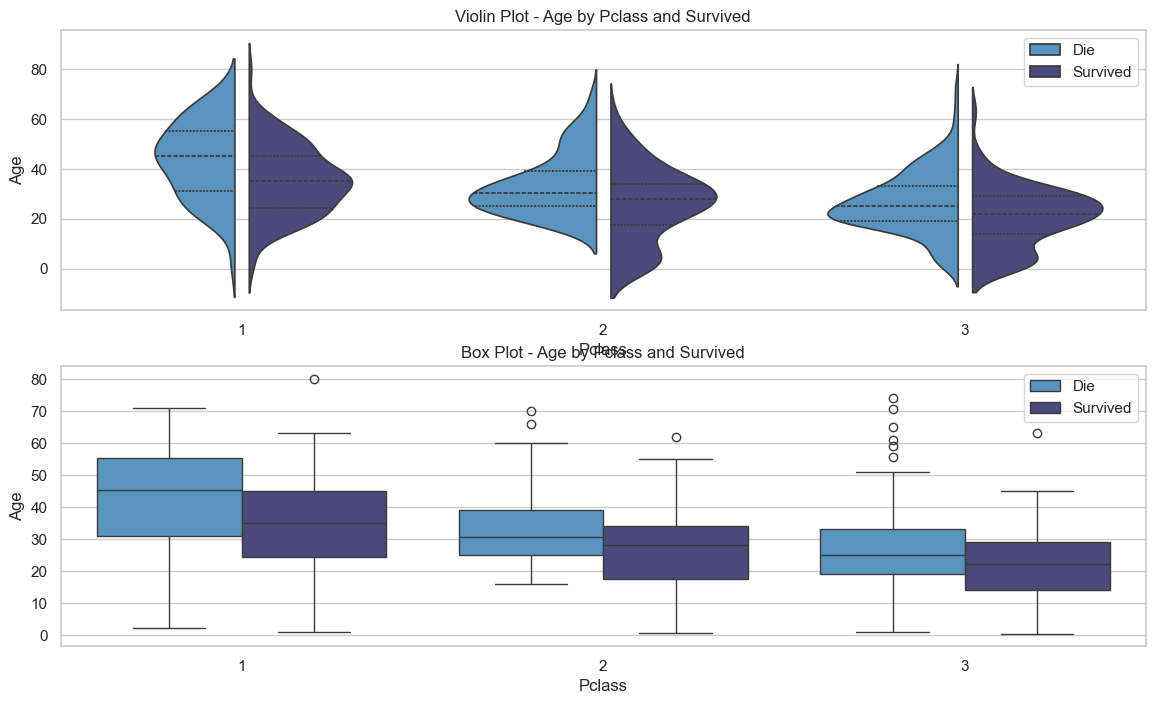

In [24]:
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(14, 8))
sns.violinplot(ax=ax1, data=Titanic, x="Pclass", y="Age", hue="Survived", split=True, gap=.1, inner="quart")
ax1.set_title('Violin Plot - Age by Pclass and Survived')
legend = ax1.get_legend()
handles = legend.legend_handles
ax1.legend(handles, ['Die', 'Survived'])

# Box plot on the second subplot (axes[1])
sns.boxplot(ax=ax2, data=Titanic, x="Pclass", y="Age", hue="Survived")
ax2.set_title('Box Plot - Age by Pclass and Survived')
legend = ax2.get_legend()
handles = legend.legend_handles
ax2.legend(handles, ['Die', 'Survived'])


## Wiek vs rodzina (przeżywalnośc) 

## Klasa vs przeżycie